#### Libraries import

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import seaborn as sns
sns.set;

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score


### DATA READING AND LOADING

In [2]:
jaam_songs = pd.read_csv('/Users/jordi.hs/Desktop/jaam_features')
print(jaam_songs.shape)
jaam_songs.head()

(200, 12)


acousticness  danceability  energy                      id  \
0      0.000973         0.653   0.934  0sSlquw5Lx9eXqlSlTrOiW   
1      0.010700         0.764   0.620  36482hNESSwELpr9sS3NbE   
2      0.039700         0.494   0.698  4aVuWgvD0X63hcOCnZtNFA   
3      0.166000         0.229   0.500  3gkijt6bxk8ts6S2RCEu4n   
4      0.102000         0.547   0.836  3DkpUR4TEV2XCxFsSL9m0r   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0          0.000512    7    0.1440    -2.878     1       0.2950  127.029   
1          0.000005    5    0.0968    -5.757     0       0.1840  129.989   
2          0.006340    6    0.1520   -12.049     0       0.0553   95.842   
3          0.000248    4    0.4540    -6.769     1       0.0312   96.022   
4          0.000000    6    0.1830    -5.361     0       0.1880  104.985   

   valence  
0    0.561  
1    0.526  
2    0.778  
3    0.185  
4    0.649

# Clustering

We are going to try three different clustering techniques to decide which fits best to our type of data.

* Hierarchical
* DBSCAN
* Gaussian Mixture Models


#### Standardization

* to ensure all features are readable and contribute to a scale when added together

In [3]:
X_user = jaam_songs.drop('id', axis=1)
scaler = StandardScaler()
X_user = scaler.fit_transform(X_user)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Hierarchical clustering

In [4]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



In [5]:
hier_clust = AgglomerativeClustering(linkage='ward', n_clusters=4).fit(X_user)
labels = hier_clust.labels_

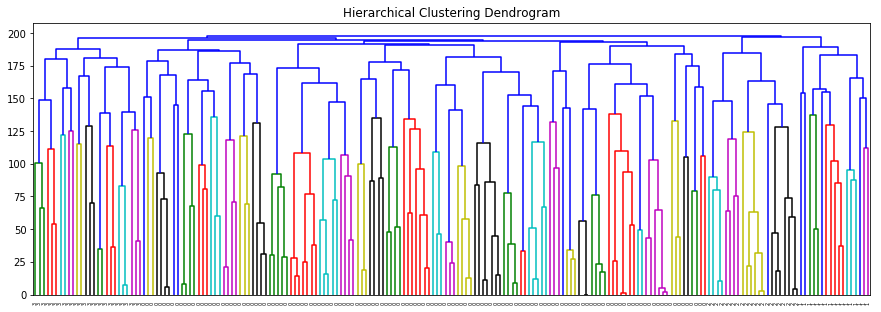

In [6]:
plt.figure(figsize=(15,5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hier_clust, labels=labels)
plt.show()

It seems really hard to estimate a cut-off point to decide the number of clusters. 

### DBSCAN

In [7]:
db = DBSCAN(eps=2.1, min_samples=5).fit(X_user)
labels = db.labels_

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 75


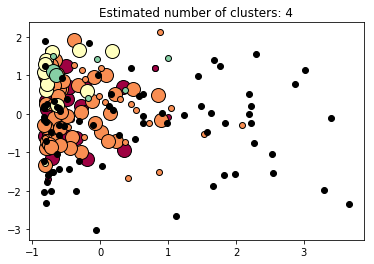

In [8]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_user[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_user[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

The DBSCAN is presenting several problems:
    
* The fact there is a great amount of observations very separate from one another are regarded for the algorithm as outliers.

* Epsilon (radius) and minimum num of points are two very sensible hyperparameters for the analysis. Despite trying several times there seems to be no perfect formula.

* There also a lot of noise points inside the populated area that the algorithm is unable to capture.

### Gaussian Mixture models

In [9]:
gmm = GaussianMixture(9, covariance_type='full', random_state=0)

In [10]:
gmm.fit(X_user)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
labels = gmm.predict(X_user)

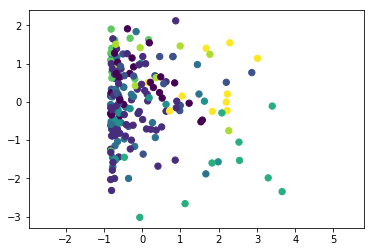

In [12]:
plt.scatter(X_user[:, 0], X_user[:, 1], c=labels, s=40, cmap='viridis');
plt.axis('equal');

In [13]:
from __future__ import print_function

range_n_clusters = range(4,10)

silhouette_list = []

for n_clusters in range_n_clusters:
 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    cluster_labels = clusterer.fit_predict(X_user)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_user, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


plt.show()

For n_clusters = 4 The average silhouette_score is : 0.14762765112910575
For n_clusters = 5 The average silhouette_score is : 0.13935252922206373
For n_clusters = 6 The average silhouette_score is : 0.06049821765352581
For n_clusters = 7 The average silhouette_score is : 0.08293090497483738
For n_clusters = 8 The average silhouette_score is : 0.11408667865483275
For n_clusters = 9 The average silhouette_score is : 0.1221534989583563


Probabilistic clustering does also not seem to be the right method, since the silhouette scores achieved are not really high.

### Conclusions

* None of these methods seem to perform accurately for our clustering. We will try K-Means on a different notebook.